# Network Graph 02_02


In [1]:
# import packages
import pandas as pd
import numpy as np
#!pip install openpyxl
import os

# network packages
#!pip install networkx
import networkx as nx
import numpy as np

# data viz
#!pip install matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors

In [2]:
# import data
df = pd.read_excel('C:\\Users\\Red30TechEmployeeDirectory.xlsx')

#convert column names back to lower to be accepted by snowflake
df.columns= df.columns.str.lower()
df.head()

C:\Users\18594\Anaconda3\envs\networks\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


first name  last name                            title        department  \
0    Ainsley    Barnett  Customer Service Representative  Customer Service   
1      Amaya       Witt         Customer Service Manager  Customer Service   
2     Jemima  Mccormick  Customer Service Representative  Customer Service   
3      Julie  Davenport  Customer Service Representative  Customer Service   
4       Thor     Watson  Customer Service Representative  Customer Service   

                      email  departmentid  employeeid  manager  
0    abarnett@red30tech.com             2           1        8  
1       awitt@red30tech.com             2           8       80  
2  jmccormick@red30tech.com             2           9        8  
3  jdavenport@red30tech.com             2          15        8  
4     twatson@red30tech.com             2          19        8

# Set up graph and get edge list

In [3]:
# Rename to and from columns to match package naming convention
# https://ona-book.org/gitbook/working.html
# A graph also be constructed from an edgelist in a Pandas DataFrame. By default, the edgelist needs to have the columns source and target
df.rename({'employeeid': 'source', 'manager': 'target'}, axis=1, inplace=True) # using store id: {'store_id_from': 'source', 'store_id_to': 'target'}

In [4]:
# create a directed graph DiGraph from the DataFrame
network = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr=['department','departmentid'], create_using=nx.DiGraph)

# check if graph is directed or not
print(network.is_directed())

# check edges
# list(network.edges)

True


# Visuals

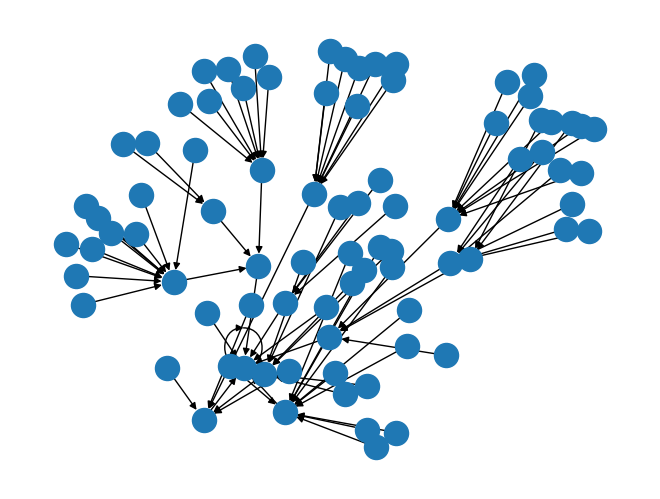

In [5]:
# visualize the network

# set seed for reproducibility
np.random.seed(123)

fig = nx.draw(network)
plt.rcParams["figure.figsize"] = (40,40)
plt.show()

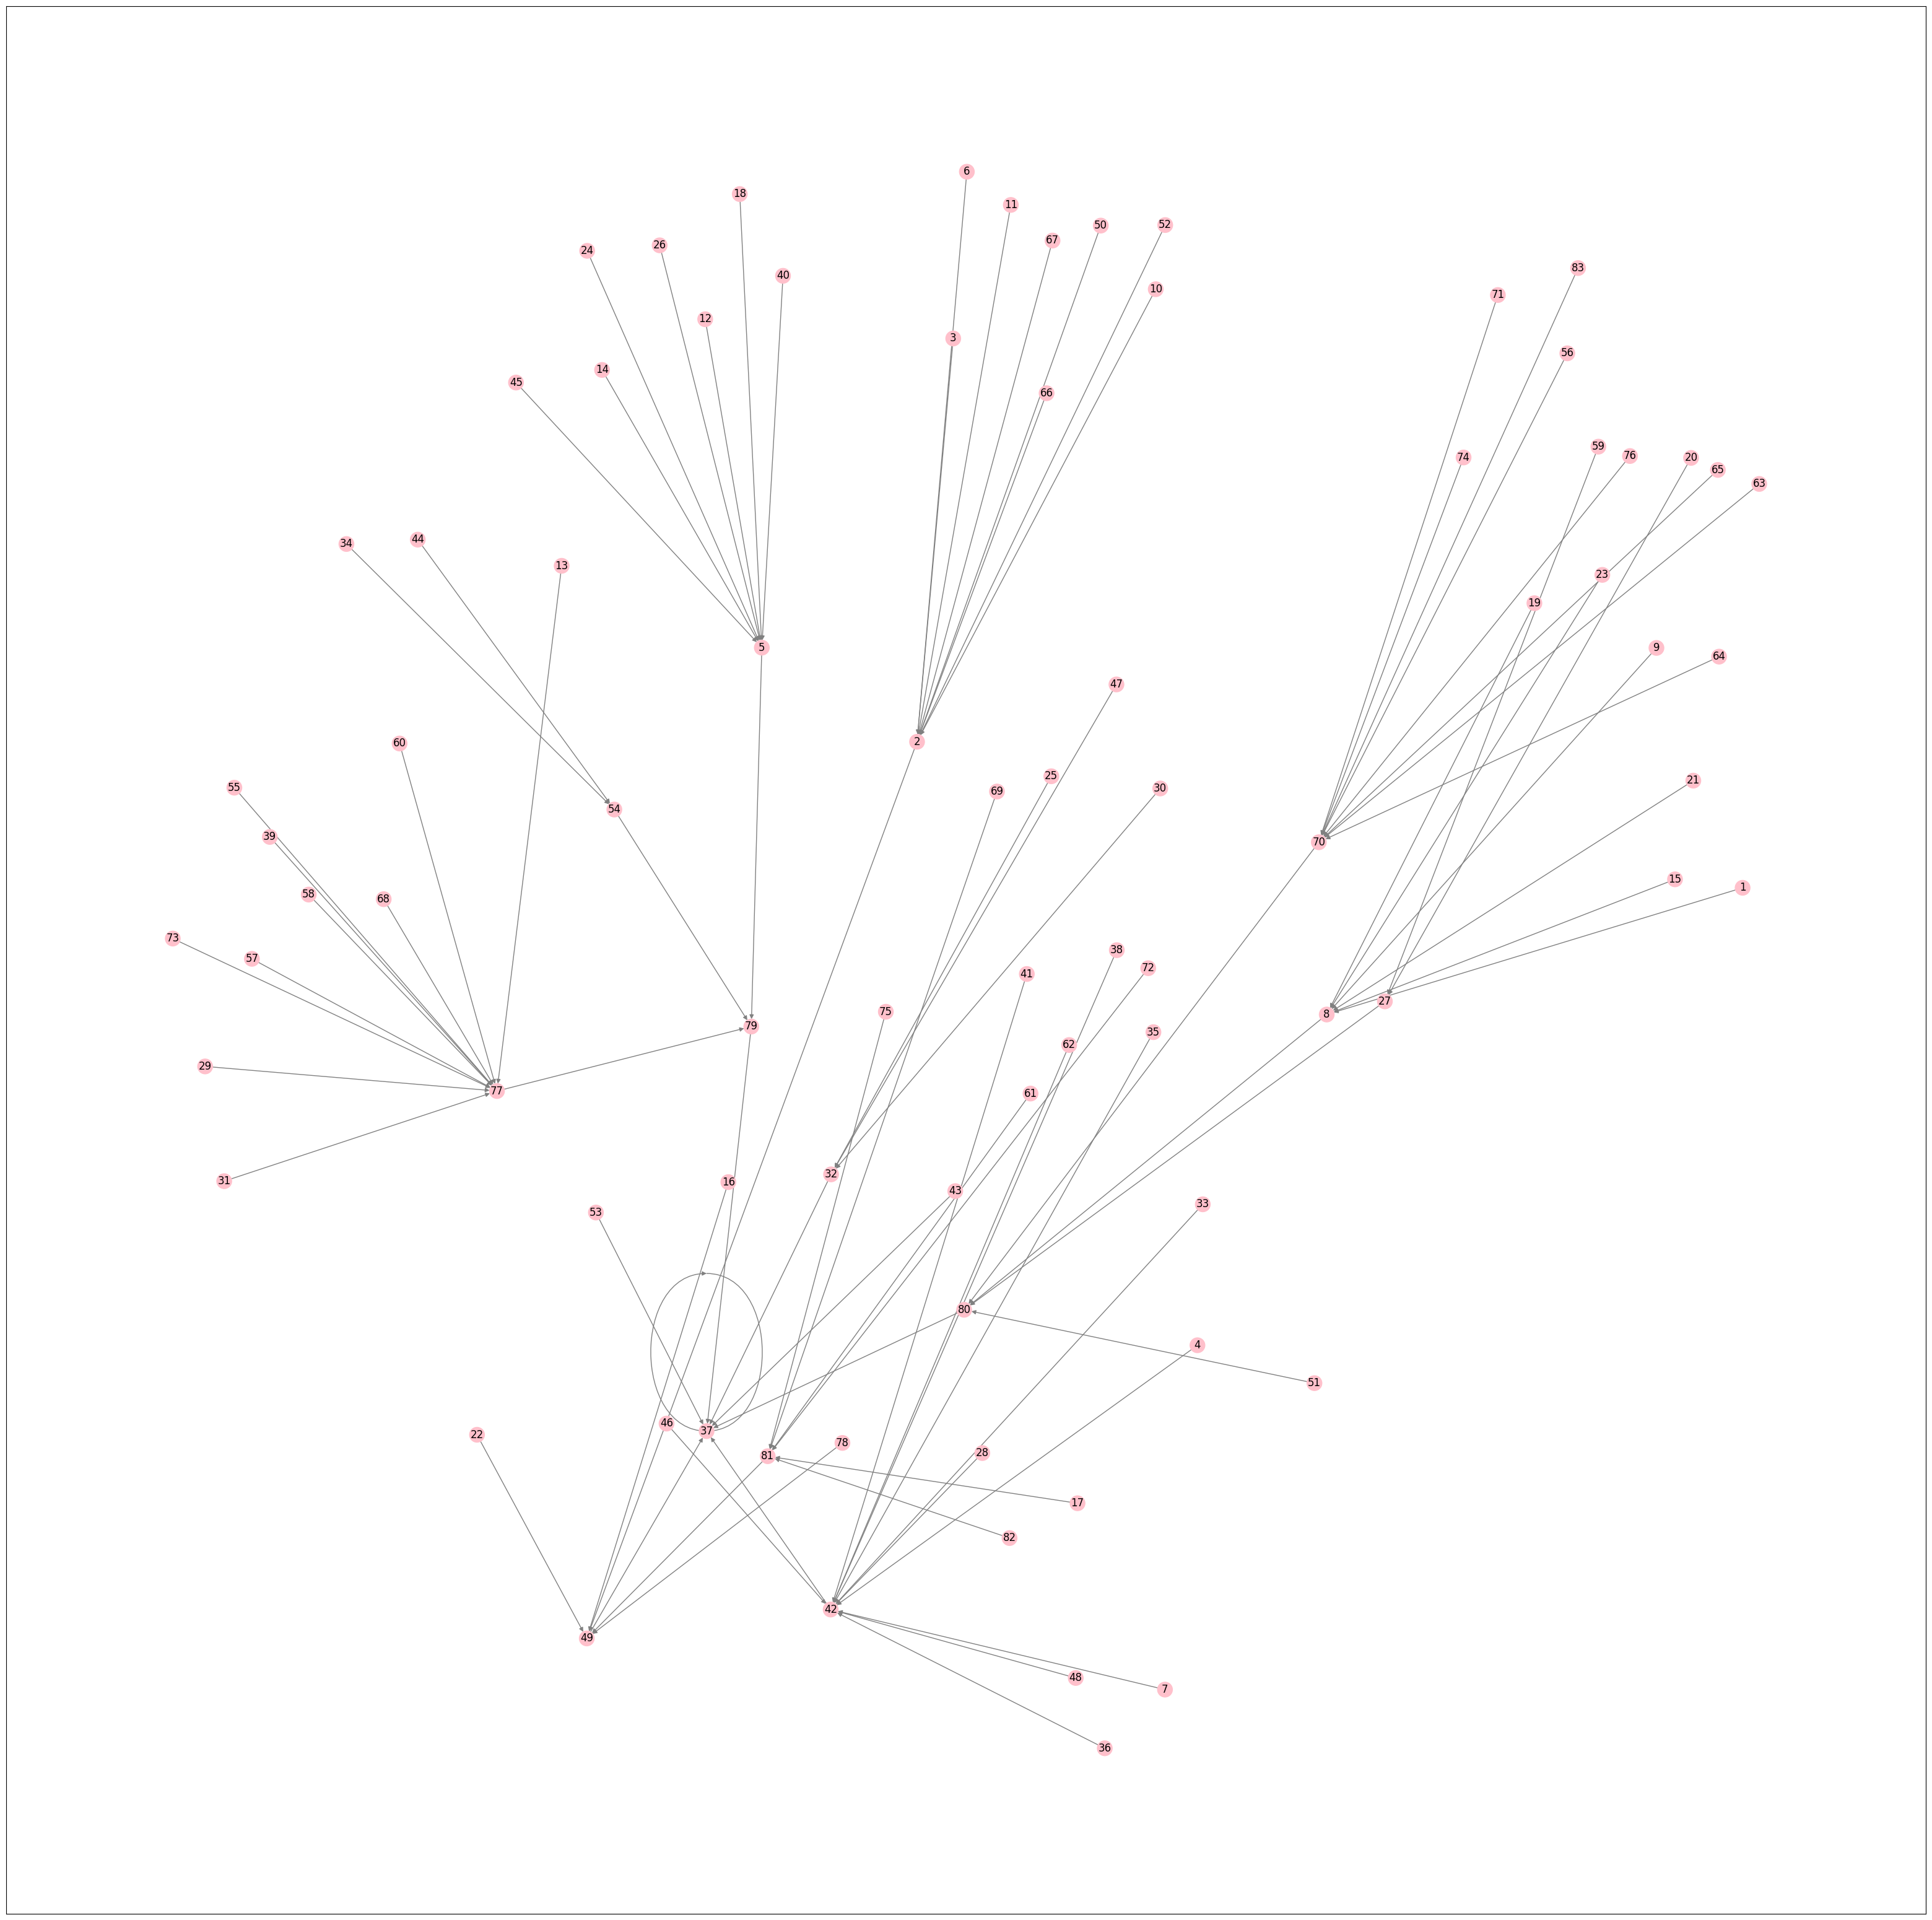

In [6]:
# set seed for reproducibility
np.random.seed(123)

# create dict with labels for each node
node = list(network.nodes)
labels = [i for i in network.nodes]
nodelabels = dict(zip(node, labels))

# create color list
colors = ["pink" for i in network.nodes]

nx.draw_networkx(network,labels = nodelabels,  node_color = colors, 
edge_color = "grey")
plt.rcParams["figure.figsize"] = (40,40)
plt.show()

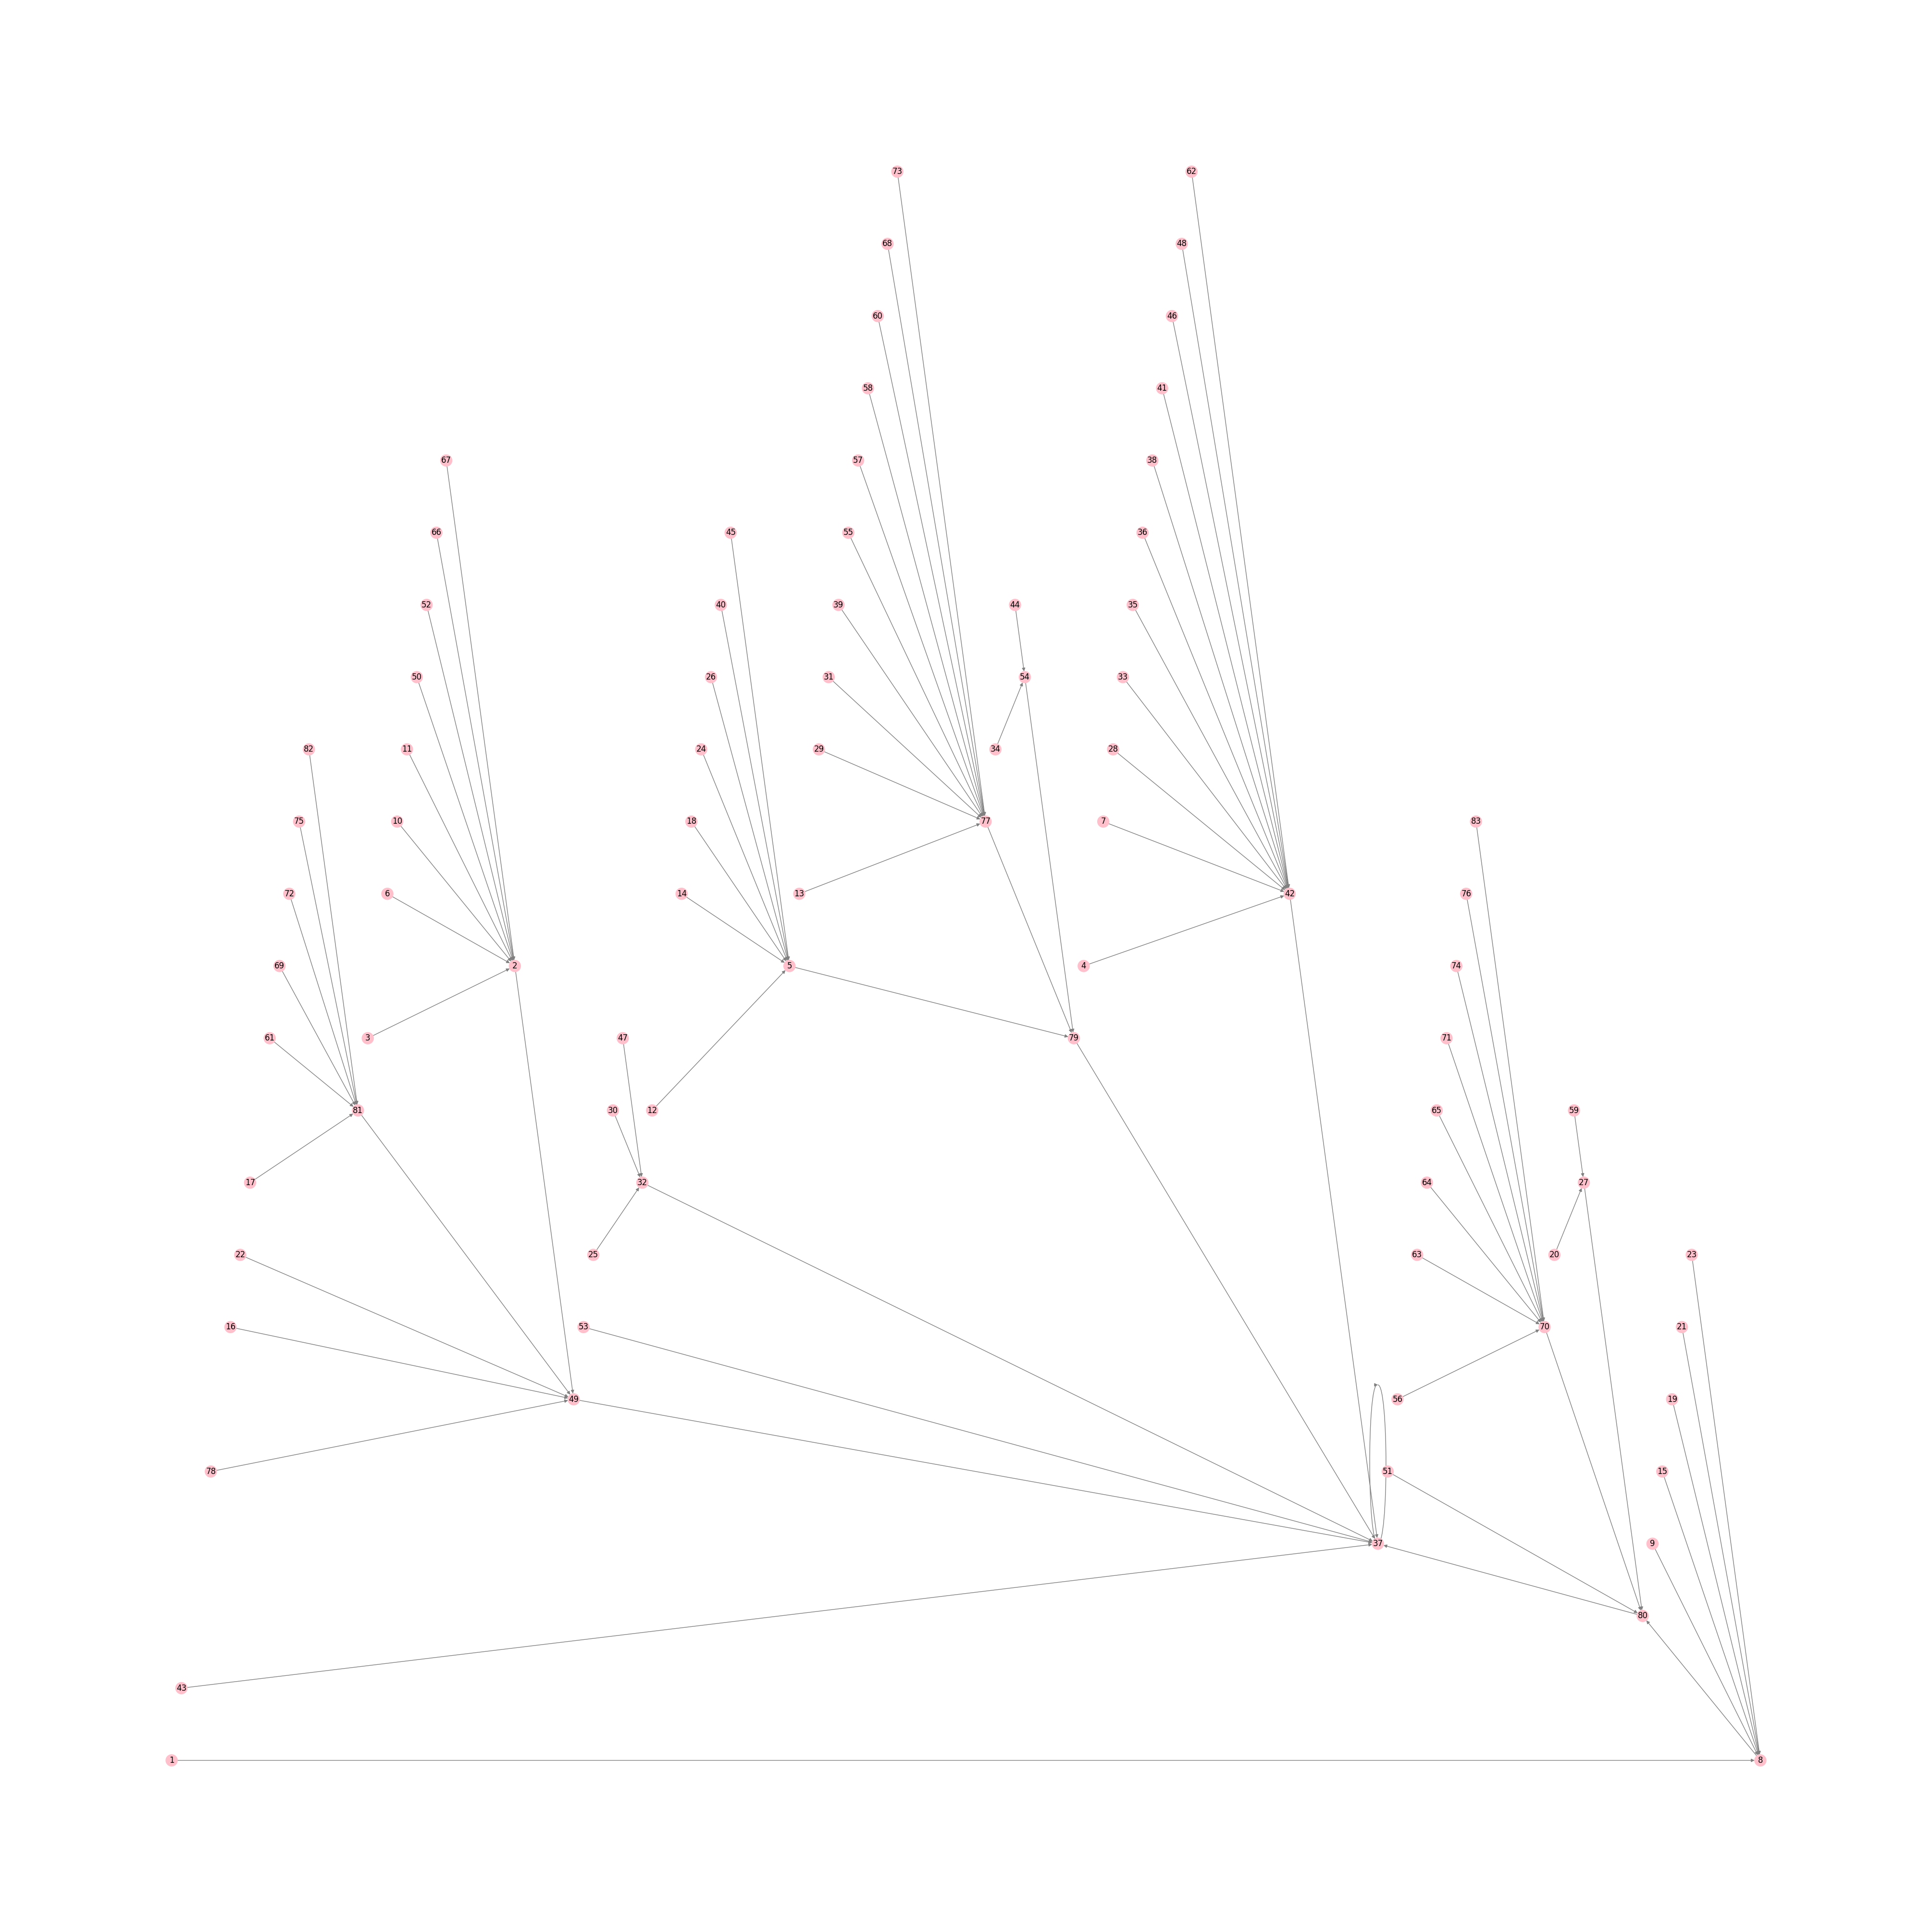

In [7]:
# planar layout does not let any edges intersect
# set seed for reproducibility
np.random.seed(123)

#edges, items = zip(*nx.get_edge_attributes(network, 'department').items()) # each edge color is determined by the item being transferred

# circular layout
nx.draw_planar(network, labels = nodelabels, node_color = colors, 
edge_color = "grey")
plt.show()

# Calculating and illustrating vertex centrality

In [8]:
# the network.in_degree shows how many people report to the person, if any
# the network.out_degree shows how many people the employee reports to (one for everyone besides the CEO) - not super relevant for this example

# create a list of employee ids to iterate through this is the s we will pass to our loops
target_emps =  df['target'].unique()

##### Good source for how to calculate various metrics: 
#### https://networkx.org/documentation/stable/reference/algorithms/centrality.html
#### https://www.geeksforgeeks.org/network-centrality-measures-in-a-graph-using-networkx-python/

# INSTANTIATE EMPTY LISTS
target = []
in_degrees = []
in_deg_cent = []

#### FOR TARGET ENTITIES - "IN" METRICS
for s in target_emps:
    #### DEGREE
    ## shows how many in edges are connected to the node
    in_degree = network.in_degree(s) 
    in_degrees.append(in_degree) 

    #### DEGREE CENTRAILITY
    in_deg_centralities = nx.in_degree_centrality(network) # calculate in-degree centraility for all nodes in the network
    val = in_deg_centralities.get(s) # grab the associated in-degree centrality value for each specific entity
    in_deg_cent.append(val) 

    ### RECORD WHICH NODE WE CALCULATED THESE ON
    target.append(s) # send the entity

In [9]:
# this df can help identify individuals that have many employees reporting to them
target_properties = pd.DataFrame(
    {'target': target,
     'in_degrees': in_degrees,
     'in_degree_centrality': in_deg_cent,
    })

# join metrics back to employee data
info = df[['first name','last name','title','source']] # only keep the cols we need from the original df - name and the employee's id
# map the number of direct reports that we got from
target_properties = pd.merge(target_properties,info,left_on='target',right_on='source',how='left')

In [10]:
#target_properties.head()
target_properties = target_properties.sort_values(by=['in_degrees'], ascending=False) # put the stores with the num of employees reporting to them first
target_properties.head()

target  in_degrees  in_degree_centrality first name last name  \
13      42          11              0.134146      Grant    Nguyen   
10      77          10              0.121951     Samuel    Brooks   
2       70           8              0.097561      Kiona   Hancock   
3       37           8              0.097561    Donovan    Jarvis   
12       2           8              0.097561      Davis      Lang   

                        title  source  
13                   VP Sales      42  
10  Manager of Communications      77  
2    Customer Service Manager      70  
3               Owner and CEO      37  
12       Lead Product Manager       2

In [11]:
# re-order and rename cols for LinkedIn Learning Slide image
target_properties = target_properties[['first name','last name','title','source','in_degrees']]
target_properties .rename({'source': 'employeeid', 'in_degrees': 'direct_report_count'}, axis=1, inplace=True) # using store id: {'store_id_from': 'source', 'store_id_to': 'target'}
target_properties

first name  last name                      title  employeeid  \
13      Grant     Nguyen                   VP Sales          42   
10     Samuel     Brooks  Manager of Communications          77   
2       Kiona    Hancock   Customer Service Manager          70   
3     Donovan     Jarvis              Owner and CEO          37   
12      Davis       Lang       Lead Product Manager           2   
9        Mary      Small              Manager UI/UX           5   
0       Amaya       Witt   Customer Service Manager           8   
7       Gavin     Medina   Chief Technology Officer          81   
4       Devin      David                        CFO          49   
1    Amethyst     Ashley        VP Customer Service          80   
6        Bert    Russell          Vice President HR          32   
8     Deborah     Harper               VP Marketing          79   
5   Guinevere      Banks                   Engineer          27   
11       Suki  Gillespie          Lead Photographer          54   

    direct_report_count  
13                   11  
10                   10  
2                     8  
3                     8  
12                    8  
9                     7  
0                     6  
7                     6  
4                     5  
1                     4  
6                     3  
8                     3  
5                     2  
11                    2

# Visualize the DiGraph 

Below are a few options for visualizing Red30Tech's Organizational Chart!
- Node colors are derived from a heat map based on number of employees who report to each individual (in degrees) - the color scale is shown on the right. As an employee has more employees reporting to them, their node color approaches red.
- Each Department receives its own edge color for a quick way to identify which sets of employees belong to the same department.

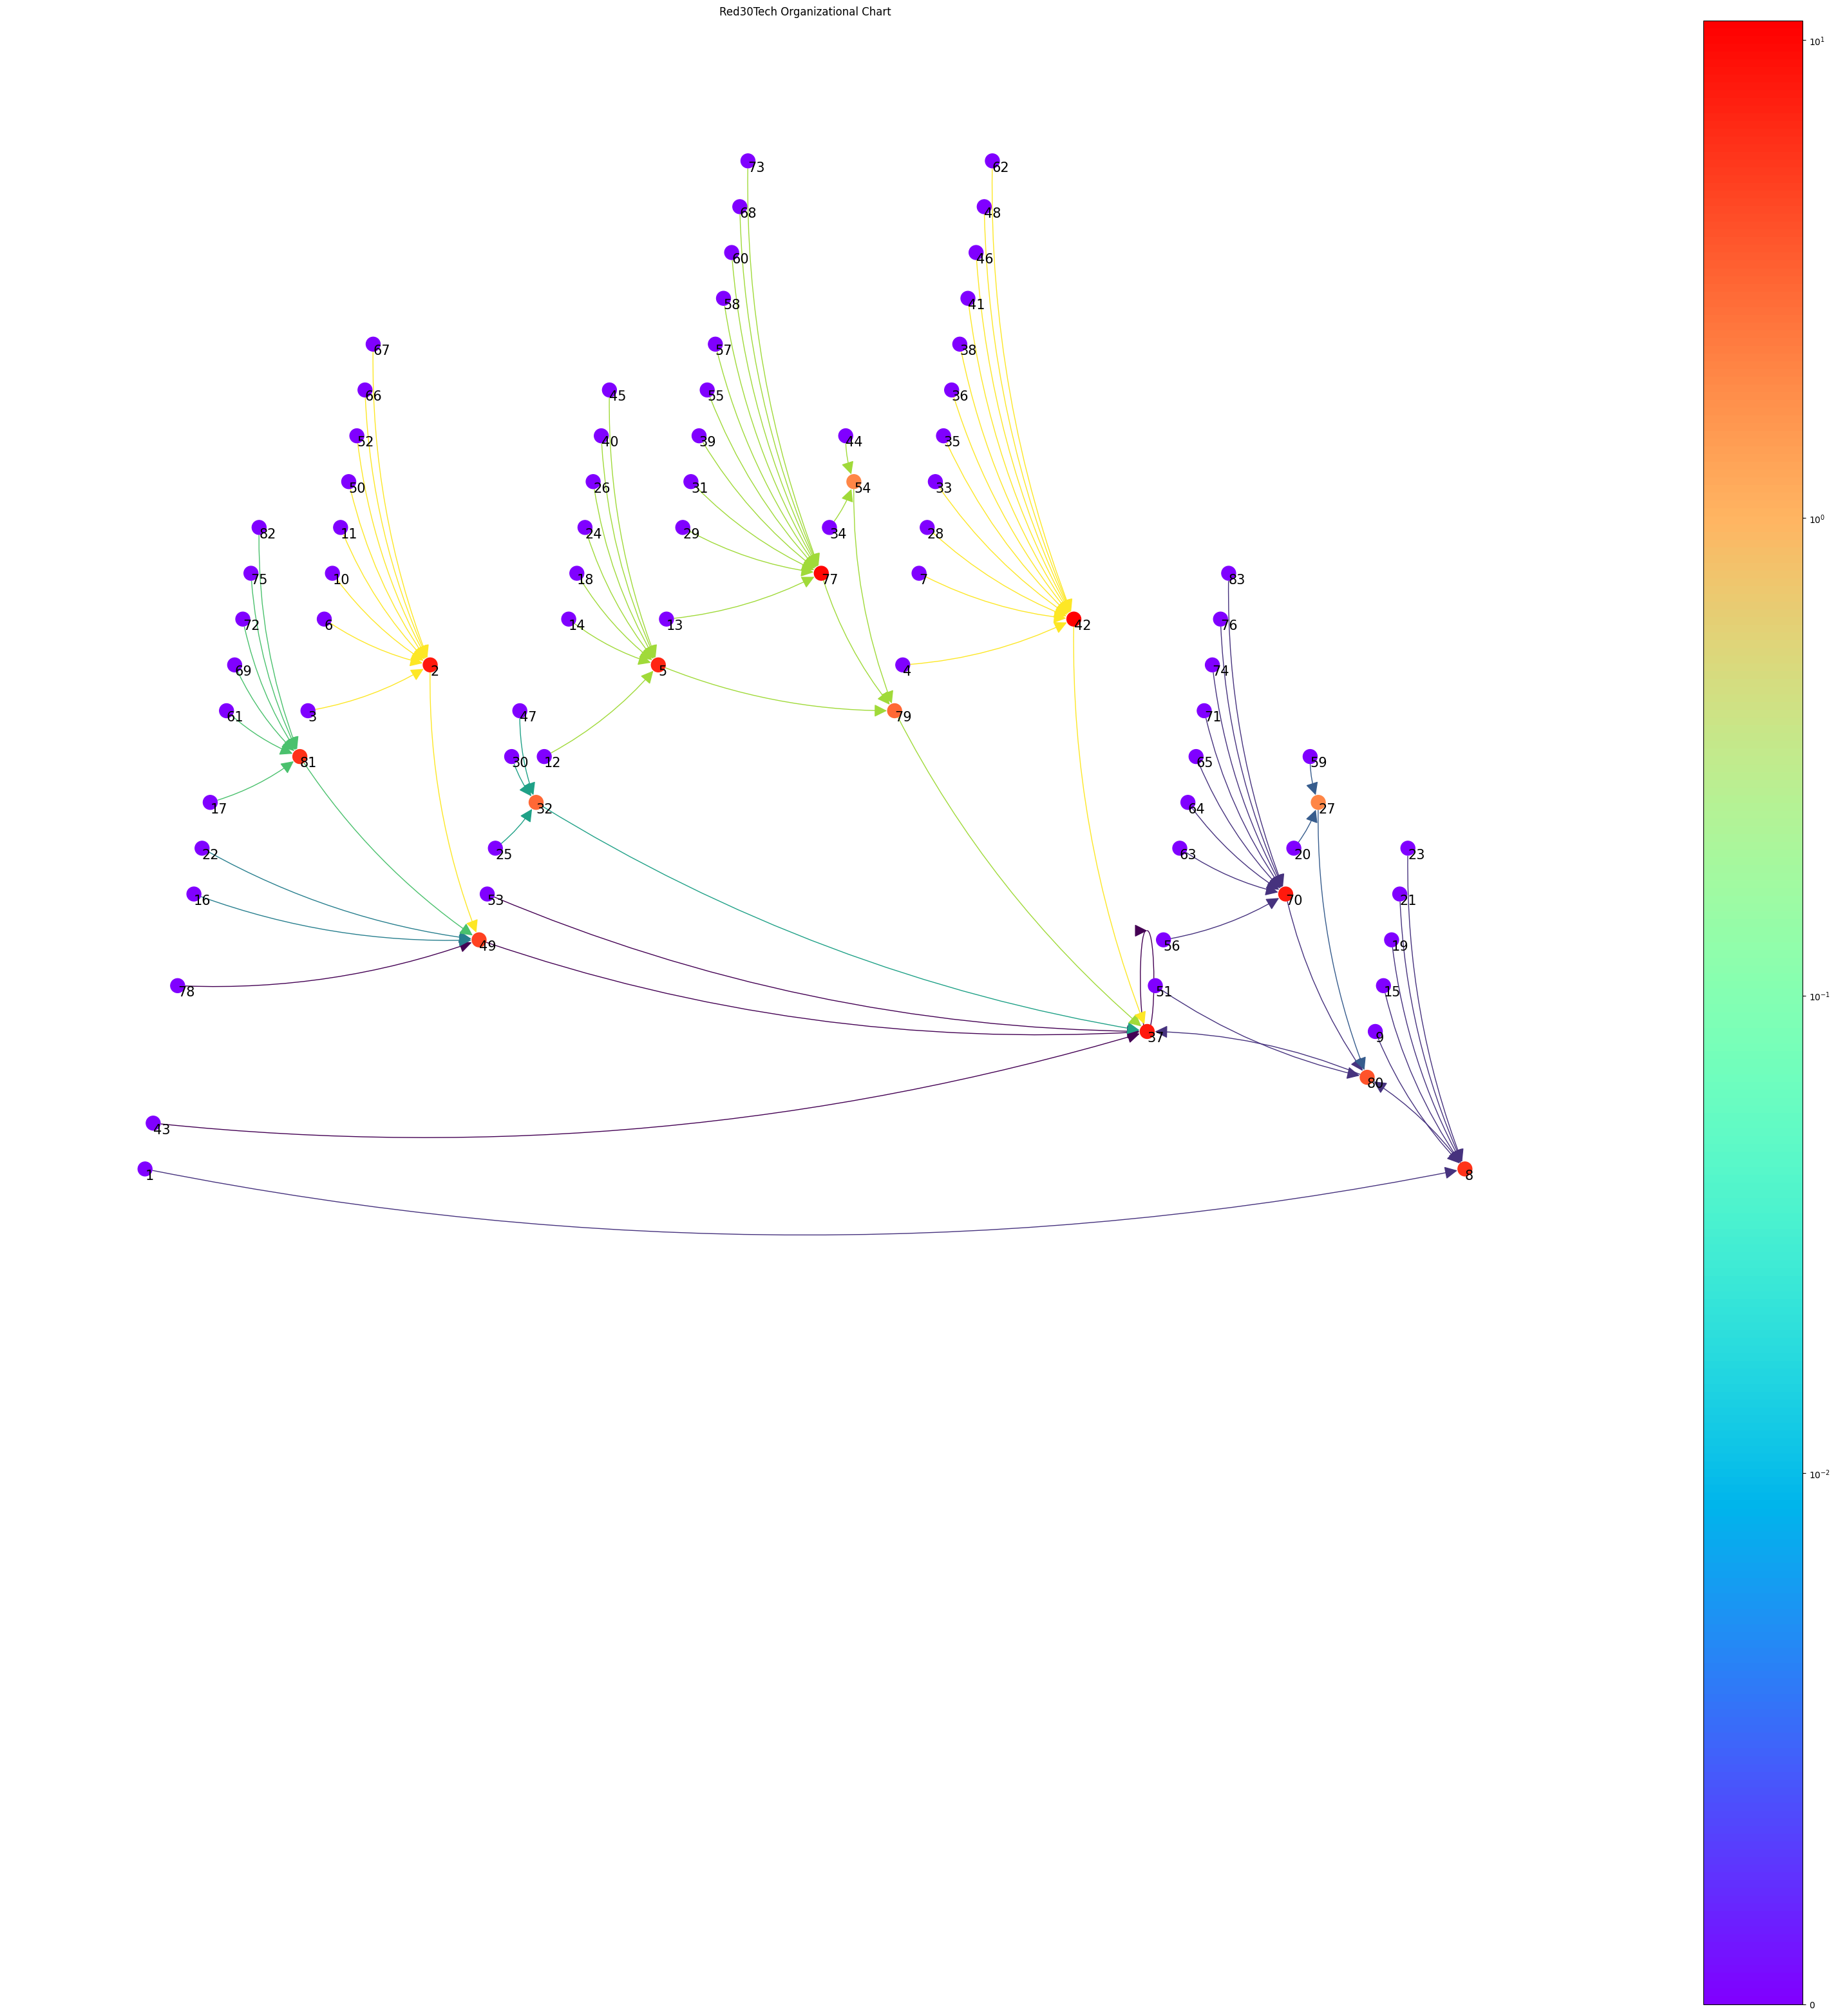

In [12]:
# https://aksakalli.github.io/2017/07/17/network-centrality-measures-and-their-visualization.html
dpos = nx.planar_layout(network) # other layout options: https://networkx.org/documentation/stable/reference/drawing.html
in_degrees = network.in_degree() 
in_degree_values = [v for k, v in in_degrees]
keys= [k for k, v in in_degrees]


def draw(G, pos, measures, measure_name):
    # create dict with labels for each node

    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=plt.cm.rainbow, 
                                   node_color=list(measures), # .values()
                                   nodelist=keys, label=list(keys))
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    edges, items = zip(*nx.get_edge_attributes(G, 'departmentid').items()) # each edge color is determined by the item being transferred
    edges = nx.draw_networkx_edges(G, pos, edge_color = items, arrowsize=30, connectionstyle='arc3,rad=0.1') # connectionstyle avoids edges being straight lines
    labels = pos
    label = nx.draw_networkx_labels(G,pos,labels={n:n for n,lab in labels.items() if n in pos},font_size=15,horizontalalignment='left', verticalalignment='top')

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.rcParams["figure.figsize"] = (40,40)
    plt.show()

draw(network, dpos, in_degree_values, 'Red30Tech Organizational Chart')

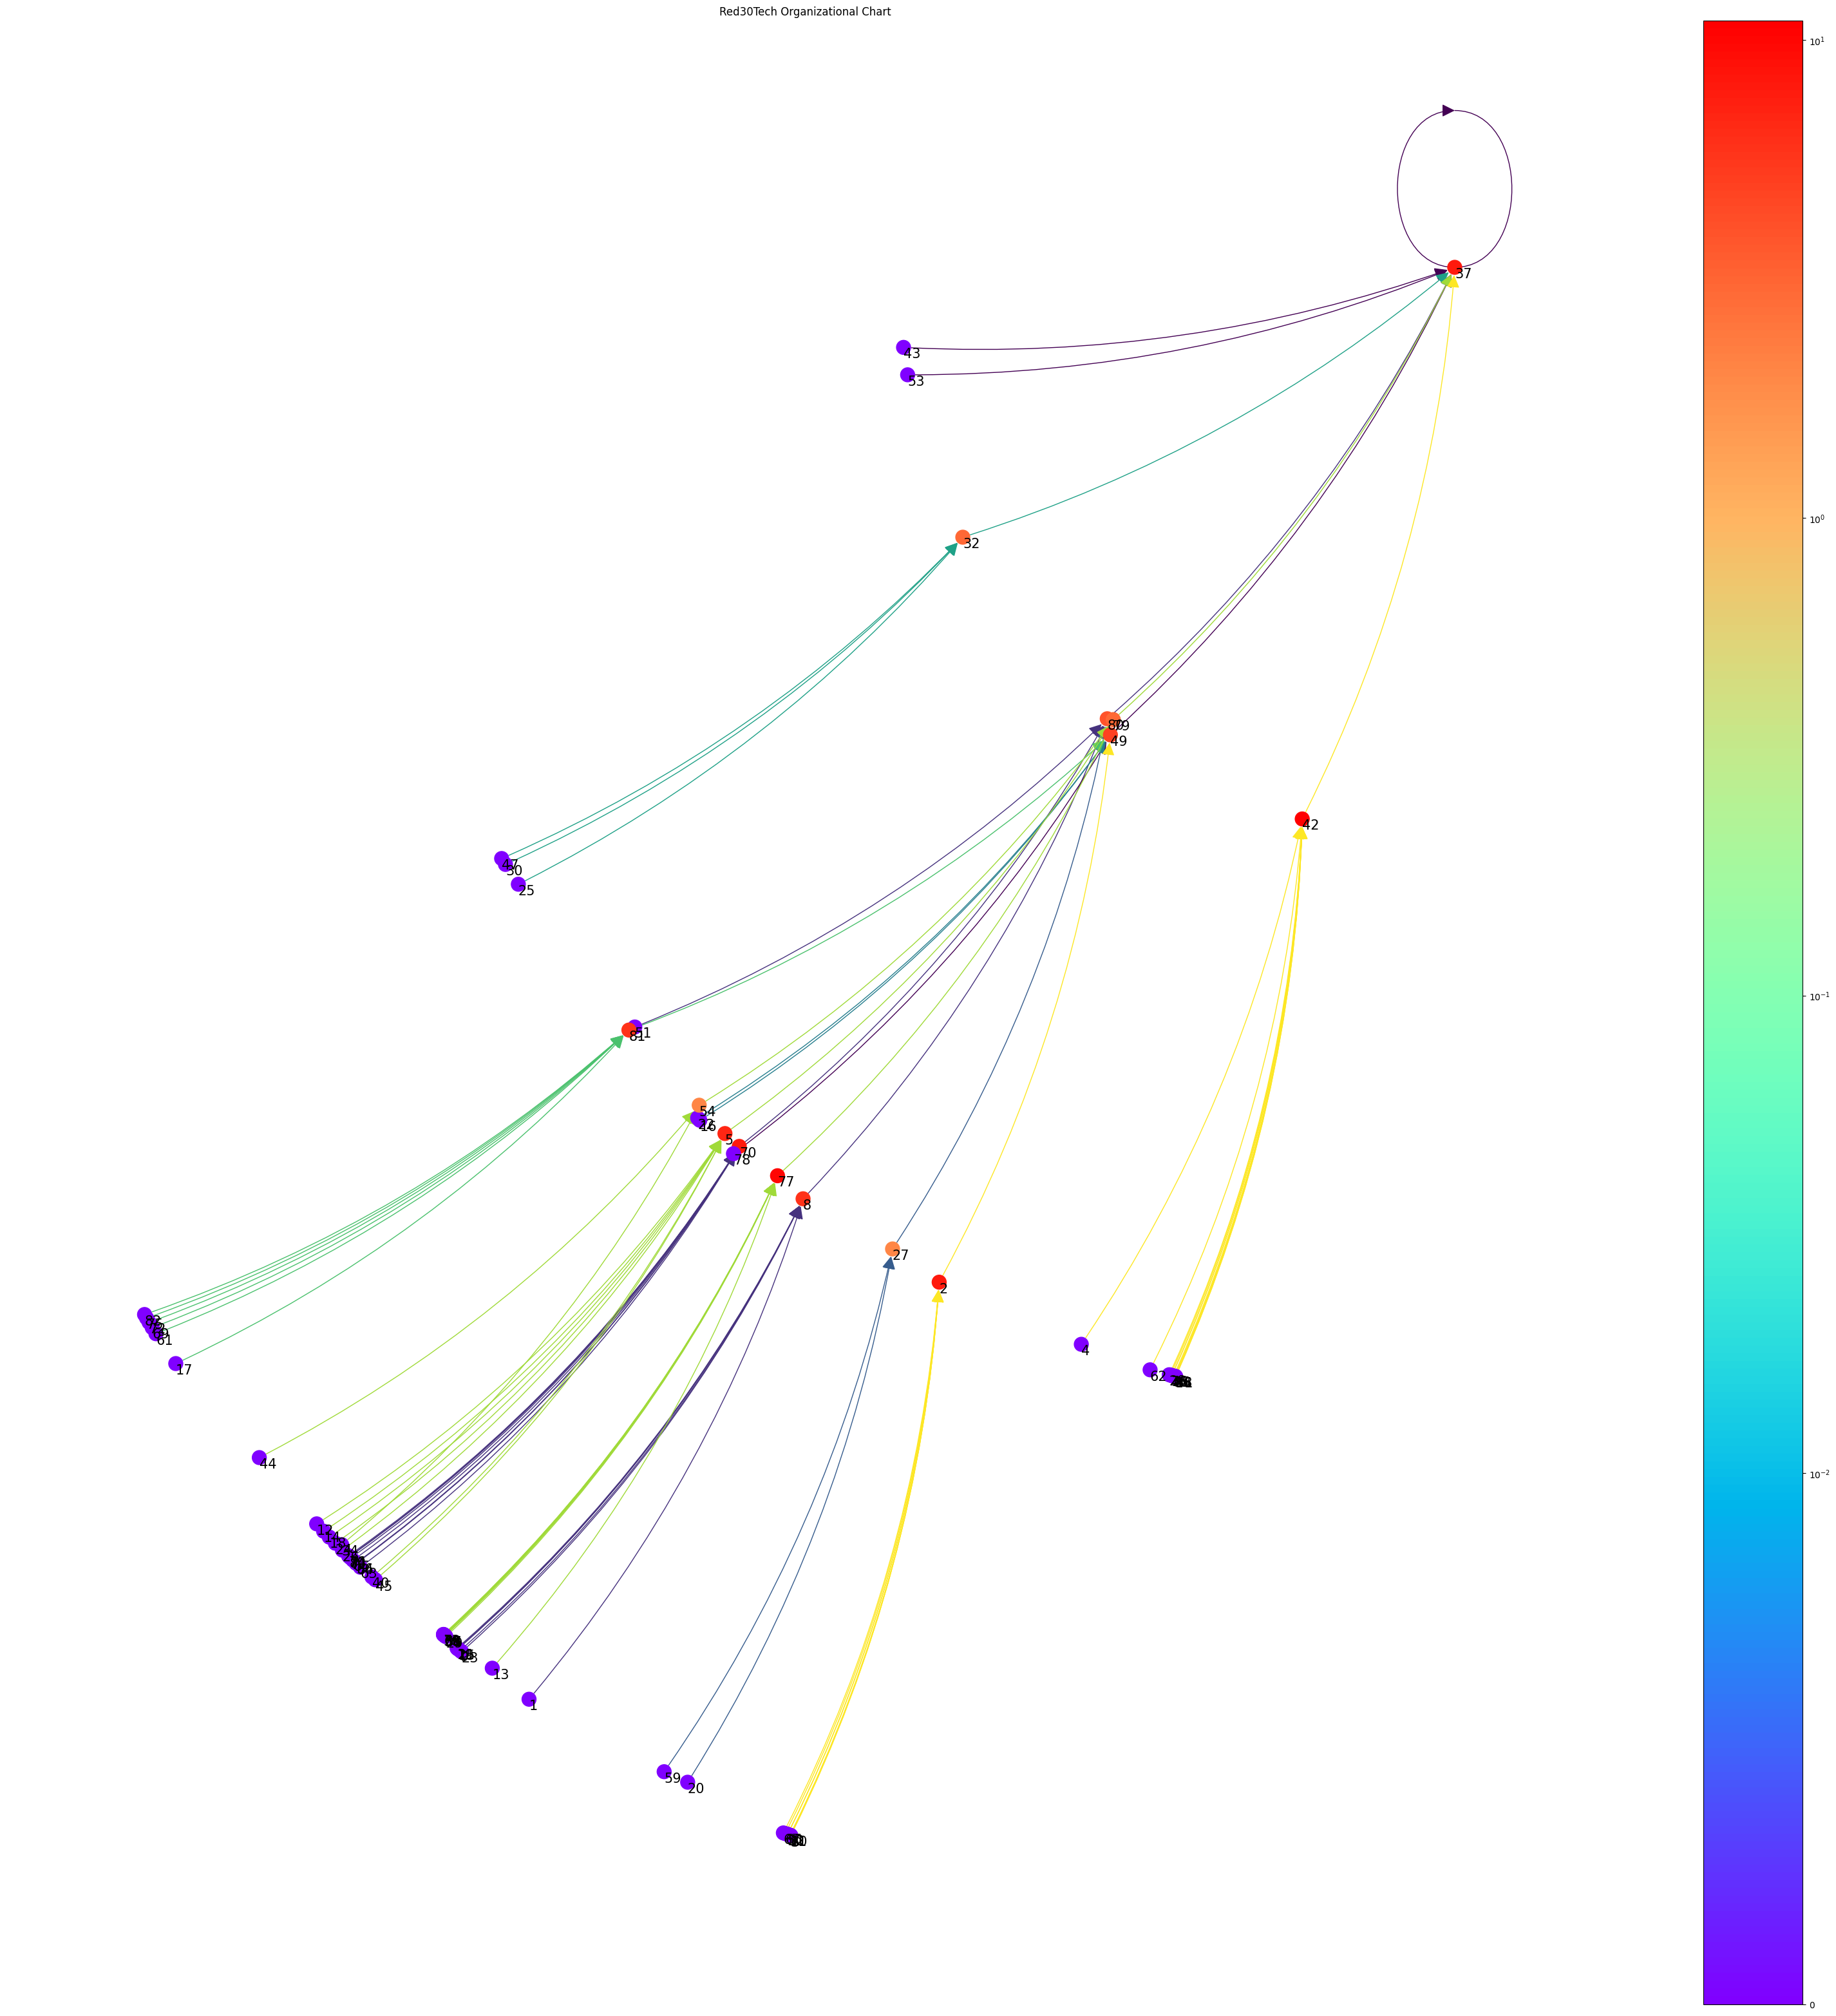

In [13]:
# https://aksakalli.github.io/2017/07/17/network-centrality-measures-and-their-visualization.html
dpos = nx.kamada_kawai_layout(network,scale=50) # other layout options: https://networkx.org/documentation/stable/reference/drawing.html
in_degrees = network.in_degree() 
in_degree_values = [v for k, v in in_degrees]
keys= [k for k, v in in_degrees]


def draw(G, pos, measures, measure_name):
    # create dict with labels for each node

    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=plt.cm.rainbow, 
                                   node_color=list(measures), # .values()
                                   nodelist=keys, label=list(keys))
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    edges, items = zip(*nx.get_edge_attributes(G, 'departmentid').items()) # each edge color is determined by the item being transferred
    edges = nx.draw_networkx_edges(G, pos, edge_color = items, arrowsize=30, connectionstyle='arc3,rad=0.1') # connectionstyle avoids edges being straight lines
    labels = pos
    label = nx.draw_networkx_labels(G,pos,labels={n:n for n,lab in labels.items() if n in pos},font_size=15,horizontalalignment='left', verticalalignment='top')

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.rcParams["figure.figsize"] = (40,40)
    plt.show()

draw(network, dpos, in_degree_values, 'Red30Tech Organizational Chart')

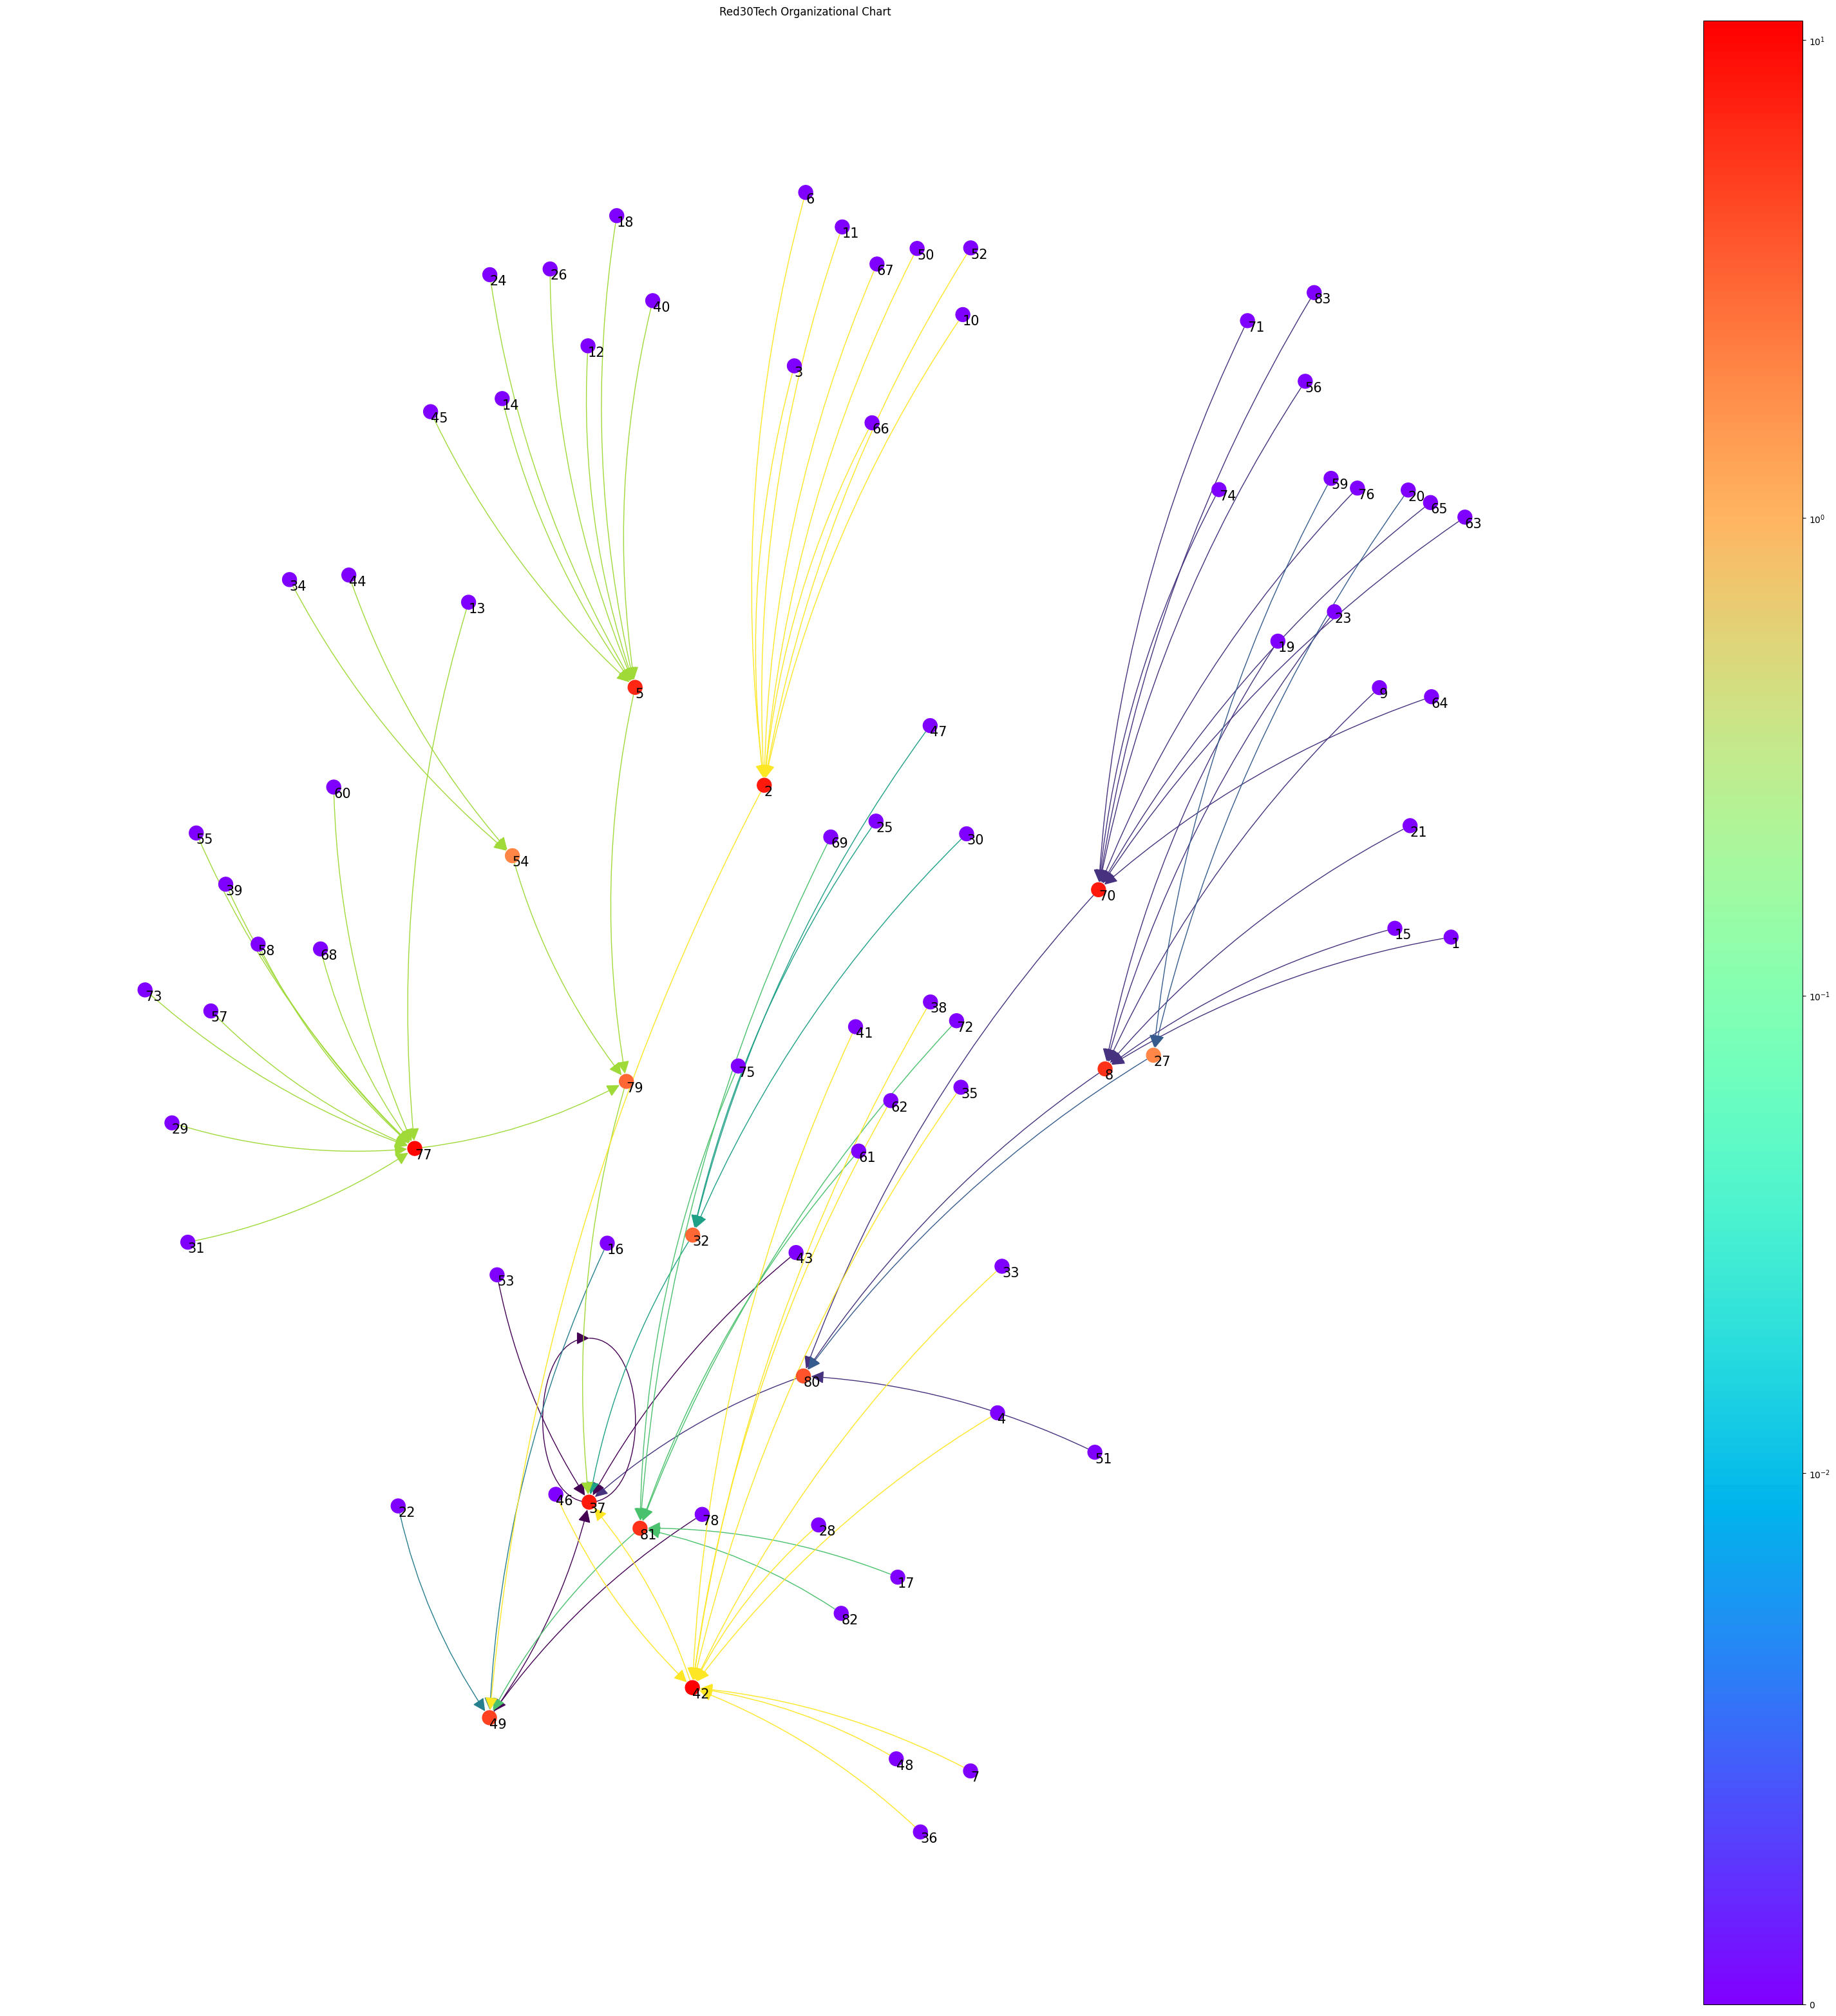

In [14]:
# https://aksakalli.github.io/2017/07/17/network-centrality-measures-and-their-visualization.html
dpos = nx.spring_layout(network,scale=500) # other layout options: https://networkx.org/documentation/stable/reference/drawing.html
in_degrees = network.in_degree() 
in_degree_values = [v for k, v in in_degrees]
keys= [k for k, v in in_degrees]


def draw(G, pos, measures, measure_name):
    # create dict with labels for each node

    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=plt.cm.rainbow, 
                                   node_color=list(measures), # .values()
                                   nodelist=keys, label=list(keys))
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    edges, items = zip(*nx.get_edge_attributes(G, 'departmentid').items()) # each edge color is determined by the item being transferred
    edges = nx.draw_networkx_edges(G, pos, edge_color = items, arrowsize=30, connectionstyle='arc3,rad=0.1') # connectionstyle avoids edges being straight lines
    labels = pos
    label = nx.draw_networkx_labels(G,pos,labels={n:n for n,lab in labels.items() if n in pos},font_size=15,horizontalalignment='left', verticalalignment='top')

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.rcParams["figure.figsize"] = (40,40)
    plt.show()

draw(network, dpos, in_degree_values, 'Red30Tech Organizational Chart')